# Assignment 2: Sentiment Classification Using Logistic Regression

## Programming Assignment (100 Points scaled to 40)

For this assignment we will be implementing a naive bayes baseline classifier. Additionally, we will be using pytorch to implement a binary logistic regression classifier. Our task is sentiment classification for hotel reviews. The input to your model will be a text review, and the output label is a 1 or 0 marking it as positive or negative.

We have provided a util.py file for loading the data, and some of the basic modeling. Your task is to fill in the functions below in order to train as accurate a classifier as possible!

We suggest browsing the util.py script first. Additionally, make sure to install dependencies from the provided requirements.txt file in a similar fashion to the pytorch tutorial. With your environment activated int he terminal, run:
```
pip install -r requirements.txt
```

In [1]:
from typing import List
import spacy
import torch
import random
import pandas as pd
import numpy as np
import math

## Section 1: Sentiment Classification Dataset (Total: 20 Points)

The training data for this task consists of a collection of short hotel reviews. The data is formatted as one review per line. Each line starts with a unique identifier for the review (as in ID-2001) followed by tab and the text of the review.  The reviews are not tokenized or sentence segmented in any way (the words are space separated). The positive reviews and negative reviews appear in separate files namely [hotelPosT-train.txt](data/hotelPosT-train.txt) and [hotelNegT-train.txt](data/hotelNegT-train.txt).

In [2]:
from util import load_train_data
pos_datapath = "data/hotelPosT-train.txt"
neg_datapath = "data/hotelNegT-train.txt"
all_texts, all_labels = load_train_data(pos_datapath, neg_datapath)

### Lets look at what is in the data

In [3]:
def random_sample(texts, labels, label):
    data_by_label = {}
    for lab, text in zip(labels, texts):
        if lab not in data_by_label:
            data_by_label[lab] = []
        data_by_label[lab].append(text)
    return random.choice(data_by_label[label])

print("--- Positive Example ---")
print(random_sample(all_texts, all_labels, label=1))
print("\n--- Negative Example ---")
print(random_sample(all_texts, all_labels, label=0))

--- Positive Example ---
This hotel was incredible. I stayed at the Holiday Inn in Binghamton, NY. The room was a perfect size, they had a mini fridge in the room which was a definite plus. The beds were comfortable and they even had soft and firm pillows! I would rate this 4/5. They were clean, and the staff was respectful. The services were perfect.

--- Negative Example ---
When we came into our room it had not been cleaned by housekeeping yet. We notified the front desk who moved us to another room. We reserved a non smoking room however the room smelled like old, stale smoke. It also had a musty odor as if there was mold or mildew somewhere. The furnishings were outdated and in poor condition. The lighting was poor which added to the drab appearance. The air conditioner was loud and leaked. The hotel was in a location that I did not feel safe in.


### Test Data ( WAIT TILL DEADLINE)

This is the test dataset that you will need to use to report the results on. This set is the unseen dataset meaning, you are not in anyway supoose to look what is in this dataset. We will release this dataset on the last day of the assignment's deadline.

In [48]:
from typing import List, Tuple, Any


def load_test_data(filepath: str) -> Tuple[List[Any], List[Any]]:
    """Load the test data, producing a List of texts, labels

    Args:
        filepath (str): Path to the training file

    Returns:
        Tuple[List[Any], List[Any]]: The texts and labels
    """
    lab_map = {'POS': 1, 'NEG': 0}
    texts = []
    labels = []
    with open(filepath, "r") as file:
        for line in file:
            idx, text, label = line.rstrip().split("\t")
            texts.append(text)
            labels.append(lab_map[label])

    return texts, labels


test_texts, test_labels = load_test_data('./data/HW2-testset.txt')

### Task 1.1: Print the number of "positive" and "negative" samples (5 Points)

It is important to know the distribution of the training examples. More often than not, you will have to work with datasets that are not "balanced" with respect to the labels of the samples. For this task, print out the number of examples that have label = 1 and label = 0, respectively, in std:out or plot a pie chart.

95
94


1

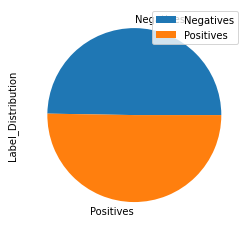

In [5]:
### ENTER CODE HERE ###

# Note since we have them in two seperate files, 
# this can also be done with bash commands
def label_distribution(labels):
    """
    TODO: Replace the line `raise NotImplementedError` with your code
    to print the labels distribution.
    """
    positives = 0
    negatives = 0
    for label in labels:
        if label == 1:
            positives+=1
        else:
            negatives+=1
    
    dataframe = pd.DataFrame({'Name': ['Positives', 'Negatives'],
                          'Label_Distribution': [positives, negatives]})
    dataframe.groupby(['Name']).sum().plot(kind='pie', y='Label_Distribution')
    print(positives)
    print(negatives)
    return 1


label_distribution(all_labels)

### Task 1.2: Split Training and Development Sets (5 Points)

For the purpose of coming with the best parameters for the model you will have to split the dataset into training and development sets. Make sure the splits follow the same distribution.

Training Label Distribution:
77
74
Development Label Distribution:
18
20


1

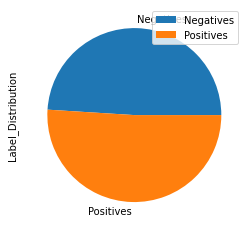

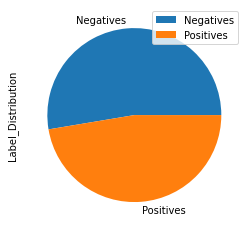

In [6]:
### ENTER CODE HERE ###
def split_data(texts, labels):
    
#     """
#     Split the dataset randomly into 80% training and 20% development set
#     Make sure the splits have the same label distribution
#     """

    split_texts = np.array(texts)
    split_label = np.array(labels)
    split_random = np.random.rand(split_texts.shape[0])    #random split for texts 
    split = split_random < np.percentile(split_random, 80) #for 80 percent
    
    X_train = split_texts[split]
    y_train = split_label[split]
    X_test = split_texts[~split]
    y_test = split_label[~split]
    
    return X_train,y_train, X_test, y_test

train_texts = all_texts
train_labels = all_labels

train_texts, train_labels, dev_texts, dev_labels = split_data(train_texts, train_labels)

print('Training Label Distribution:')
label_distribution(train_labels)

print('Development Label Distribution:')
label_distribution(dev_labels)

### Task 1.3: Evaluation Metrics (10 Points)

Implement the evaulation metrics: Accuracy, Precision, Recall and F1 score

In [7]:
### ENTER CODE HERE ###

def accuracy(predicted_labels, true_labels):
    n = len(predicted_labels)
    i = 0
    j = 0
    true_count = 0
    while(i<n):
        if predicted_labels[i] == true_labels[i]:
            true_count+=1
        i+=1
    
    false_count = 0
    while(j<n):
        if predicted_labels[j] != true_labels[j]:
            false_count+=1
        j+=1
        
    ans = true_count/(true_count + false_count)
    
    return ans

def precision(predicted_labels, true_labels):
    n = len(predicted_labels)
    i = 0
    j = 0
    count_tp = 0
    while(i<n):
        if (predicted_labels[i] == 1) and (true_labels[i]==1):
            count_tp+=1
        i+=1
    count_fp = 0
    while(j<n):
        if (predicted_labels[j] == 1) and (true_labels[j]==0):
            count_fp+=1
        j+=1
    
    ans = count_tp / (count_tp + count_fp)
    return ans

def recall(predicted_labels, true_labels):
    n = len(predicted_labels)
    i = 0
    j = 0
    count_tp = 0
    while(i<n):
        if (predicted_labels[i] == 1) and (true_labels[i]==1):
            count_tp+=1
        i+=1
    count_fn = 0
    while(j<n):
        if (predicted_labels[j] == 0) and (true_labels[j]==1):
            count_fn+=1
        j+=1
    ans = count_tp / (count_tp + count_fn)
    
    return ans

def f1_score(predicted_labels, true_labels):
    pl = predicted_labels
    tl = true_labels
    pre = precision(pl, tl)
    rec = recall(pl, tl)
    ans = (pre*rec)/(pre + rec)
    return 2*float(ans)


In [8]:
### DO NOT EDIT ###

em_test_labels = [0]*6 + [1]*4
em_test_predictions = [0]*8 + [1]*2

em_test_accuracy = 0.8
em_test_precision = 1.0
em_test_recall = 0.5
em_test_f1 = 2/3
assert accuracy(em_test_predictions, em_test_labels) == em_test_accuracy
assert precision(em_test_predictions, em_test_labels) == em_test_precision 
assert recall(em_test_predictions, em_test_labels) == em_test_recall
assert f1_score(em_test_predictions, em_test_labels) == em_test_f1

print('All Test Cases Passed!')

All Test Cases Passed!


## Section 2: Baselines (Total: 20 Points)

It is important to come up with baselines for the classifications to compare the more complicated models with. The baselines are also useful as a debugging method for your actual classfication model. You will create two baselines:

1. Random Chance
2. Naive Bayes Classifier

### Task 2.1: Random Chance Classifier (5 Points)

A random chance classifier predicts the label according to the label's distribution. As an example, if the label 1 appears 70% of the times in the training set, you predict 70 out of 100 times the label 1 and label 0 30% of the times

In [9]:
### ENTER CODE HERE ###

def predict_random(train_labels, num_samples):
    """
    Using the label distribution, predict the label num_sample number of times
    """
    prediction = []
    count_of_1 = 0
    for i in train_labels:
        if train_labels[i] == 1:
            count_of_1+=1
    count_of_0 = len(train_labels) - count_of_1
    for i in range(num_samples):
        pos = random.random()
        if (pos < count_of_1):
            prediction.append(1)
        else:
            prediction.append(0)
            
    return prediction

### Task 2.2: Naive Bayes Classifier (Total: 10 Points)

In the class, Jim went over how to implement a Naive Bayes Classifier using the tokens in the training samples.
In this task, you will do the same. As a preprocessing step, you might want to remove the stop words and lemmatize/stem the words of the texts. 

### Spacy Model https://spacy.io

To tokenize the text and help extract features from text, we will use the popular spaCy model

In [10]:
### DO NOT EDIT ###

# Initialize the spacy model
nlp = spacy.load('en_core_web_sm')

### Task 2.2.1: Play around with spacy (0 Points)

In [11]:
### ENTER CODE HERE ###

test_string = "This is an amazing sentence"

# parse the string with spacy model
test_doc = nlp(test_string)

print('Token', 'Lemma', 'Is_Stopword?')
for token in test_doc:
    print(token, token.lemma_, token.is_stop)

Token Lemma Is_Stopword?
This this True
is be True
an an True
amazing amazing False
sentence sentence False


### Task 2.2.2: Preprocessing (5 Points)

Remove stopwords and lemmatize the words of a text

In [12]:
### ENTER CODE HERE ###
import numpy
def pre_process(text: str) -> List[str]:
    """
    remove stopwords and lemmatize and return an array of lemmas
    """
    chars = text.split(' ')
    doc1 = nlp(text)
    root_list = []
    for token in doc1:
        root_list.append(token.text)
        
    processed_sentence = []
    for word in root_list:
        lex = nlp.vocab[word]
        if lex.is_stop == False:
            processed_sentence.append(word)
            
    sentence = ' '
    
    for x in processed_sentence:
        sentence += ' ' + x
        
    doc2 = nlp(sentence)
    
    lemma=[]
    for token in doc2:
        lemma.append(token.lemma_)
    lemmas = numpy.array(lemma)
    
    return lemmas

    
test_string = "This sentence needs to be lemmatized"

assert len({'sentence', 'need', 'lemmatize', 'lemmatiz'}.intersection(pre_process(test_string))) >= 3

print('All Test Cases Passed!')

All Test Cases Passed!


### Task 2.2.3: The Naive Bayes Class (5 Points)

The standard way of implementing classifiers like Naive Bayes is to implement the two methods: "fit" and "predict". The fit method expects the training data along with labels, and the predict method predicts the labels for the provides texts of samples.

In [13]:
### ENTER CODE HERE ###
import re
import math
df = dict()
df_probab = dict()


class NaiveBayesClassifier:
    
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.label_word_counter = {}
        self.label_words_count = {}
    
    def fit(self, texts, labels):
        """
        1. Group samples by their labels
        2. Preprocess each text
        3. Count the words of the text for each label
        """
        i = 0
        n = len(texts)
        list_of_1 = []
        list_of_0 = []
        
        while(i<n):
            if labels[i] == 1:
                list_of_1.append(texts[i])
            else:
                list_of_0.append(texts[i])
            i+=1
            
                
        list_of_1 = ' '.join(list_of_1)
        list_of_0 = ' '.join(list_of_0)
        chars_of_1 = pre_process(list_of_1)
        chars_of_0 = pre_process(list_of_0)
        global df
        
        for i in chars_of_0:
            if i in df:
                df[i][0]+=1
            else:
                df[i] = [1,0]
        
        for i in chars_of_1:
            if i in df:
                df[i][1]+=1
            else:
                df[i] = [0,1]
                
        global df_probab
        
        for text, value in df.items():
            pos_probab = (value[1] + 1)/(len(df) + len(chars_of_1))
            neg_probab = (value[0] + 1)/(len(df) + len(chars_of_0))
            df_probab[text] = [pos_probab, neg_probab]
            
        #print(df['visit'])
        
        return len(chars_of_1),len(chars_of_0)
    
    def predict(self, texts):
        """
        1. Preprocess the texts
        2. Predict the class by using the likelihood with Bayes Method and Laplace Smoothing
        """
        count_of_0 = 0
        count_of_1 = 0
        prediction = []
        texts_unique = set(texts)
        unique_count = len(texts_unique)
        n = len(texts)
        for i in texts:
            chars = pre_process(i)
            count_of_0 = 1
            count_of_1 = 1
            for element in chars:
                #print(df_probab)
                if element in df_probab:
                    count_of_0 *= df_probab[element][0]
                    count_of_1 *= df_probab[element][1]
            
            if(count_of_0 > count_of_1):
                prediction.append(1)
            else:
                prediction.append(0)
            
        
        return prediction
        

### Task 2.3: Baseline Results  (5 Points)

Since there is not hyperparameter-tuing required for the baselines, we can use the entirety of the training set (no need to split the dataset into train and development). Report the results you achieve with the two baselines by running the following cell:

In [14]:
### DO NOT EDIT ###

### DEV SET RESULTS

testset_prediction_random = predict_random(train_labels, num_samples=len(dev_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, dev_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(train_texts, train_labels)
testset_predictions_nb = naive_bayes_classifier.predict(all_texts)
#print(testset_predictions_nb)
#print(all_labels)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, all_labels))

Random Chance F1: 0.6428571428571429
Naive Bayes F1: 0.9304812834224598


In [15]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

testset_prediction_random = predict_random(all_labels, num_samples=len(test_labels))
print('Random Chance F1:', f1_score(testset_prediction_random, test_labels))

naive_bayes_classifier = NaiveBayesClassifier(num_classes=2)
naive_bayes_classifier.fit(all_texts, all_labels)
testset_predictions_nb = naive_bayes_classifier.predict(test_texts)
print('Naive Bayes F1:', f1_score(testset_predictions_nb, test_labels))

Random Chance F1: 0.6666666666666666
Naive Bayes F1: 0.8727272727272728


## Section 3: Logistic Regression on Features (Total: 60 Points)

Now let's try building a logistic regression based classifier on hand-engineered features.

The following tasks are going to be the implementation of the components required in building a Logistic Regressor.

### Task 3.0: Feature Extraction (20 points)

This is perhaps the most challenging part of this assignment. In the class, we went over how to featurize text for a classification system for sentiment analysis. In this assignment, you should implement and build upon this to accuractely classify the hotel reviews.

This task requires a thorough understanding of the dataset to answer the important question, "What is in the data?". Please go through some of the datapoints and convert the signals that you think might help in identifying "sentiment" as features.

Please refer to the section in Jim's book that illustrates the process of feature engineering for this task. We have attached an image of the table below:

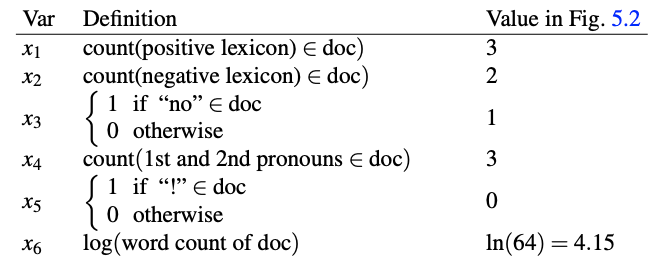

Please use the files with postive and negative words attached in the assignment: [positive_words.txt](data/poisitive-words.txt) and  [negative_words.txt](data/negative-words.txt)

In [16]:
positive_data = "data/positive-words.txt"
negative_data = "data/negative-words.txt"

positive_list = []
negative_list = []

with open(positive_data) as document:
    for line in document:
        positive_list.append(line.strip())
        

with open(negative_data) as document:
    for line in document:
        negative_list.append(line.strip())


def count_common(text: spacy.tokens.doc.Doc, list_common):
    return sum([1 for word in text if word.text in list_common])

def make_test_feature_pos(text: spacy.tokens.doc.Doc):
    value = count_common(text, positive_list)
    return value

def make_test_feature_neg(text: spacy.tokens.doc.Doc):
    value = count_common(text, negative_list)
    return value

def make_test_feature_pronouns(text: spacy.tokens.doc.Doc):
    m = []
    for n in text.noun_chunks:
        m.append(n.text)
    return len(m)

def make_test_feature_no(text: spacy.tokens.doc.Doc):
    if 'no' in text.text :
        return 1
    else:
        return 0

def make_test_feature_exc(text: spacy.tokens.doc.Doc):
    if '!' in text.text :
        return 1
    else:
        return 0

def make_test_feature_total(text: spacy.tokens.doc.Doc):
    return math.log(len(text))

def extract_features(text: spacy.tokens.doc.Doc):
    features = []
    # TODO: Replace this with your own feature extraction functions.
    features.append(make_test_feature_pos(text))
    features.append(make_test_feature_neg(text))
    features.append(make_test_feature_pronouns(text))
    features.append(make_test_feature_no(text))
    features.append(make_test_feature_exc(text))
    features.append(make_test_feature_total(text))
    # TODO: add more features to the feature vector
    
    return features

In [17]:
### ENTER CODE HERE ###
### DO NOT CHANGE THE SIGNATURE OF THE function THOUGH ###

def featurize_data(texts, labels):
    features = [
        extract_features(doc) for doc in nlp.pipe(texts)
    ]
    return torch.FloatTensor(features), torch.FloatTensor(labels)

### Task 3.0.2: Feature Scaling (10 Points)

In this task we will use the data normalization technique to ensure the scales of the feature are consistent.
After featurizing the dataset, we need to call the following function before passing it to the classifier

#### Normalization Formula

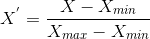

In [18]:
### ENTER CODE HERE ###

def normalize(features: torch.Tensor) -> torch.Tensor:
    """
    return the features transformed by the above formula of normalization
    """
    features_pro = []
    
    for i in features:
        min1,max1 = i.min(),i.max()
        vector = [(x - min1) / (max1 - min1) for x in i]
        features_pro.append(vector)
        
    return torch.FloatTensor(features_pro)

## Training a Logistic Regression Classifier (Total: 30 Points)

In this section, you will implement the components needed to train the binary classifier using logistic regression

### Here we define our pytorch logistic regression classifier (DO NOT EDIT THIS)

In [19]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        # We force output to be one, since we are doing binary logistic regression
        self.output_size = 1
        self.coefficients = torch.nn.Linear(input_dim, self.output_size)
        # Initialize weights. Note that this is not strictly necessary,
        # but you should test different initializations per lecture
        initialize_weights(self.coefficients)
        
    def forward(self, features: torch.Tensor):
        # We predict a number by multipling by the coefficients
        # and then take the sigmoid to turn the score as logits
        return torch.sigmoid(self.coefficients(features))

### Task 3.1: Initialize the weights. (5 Points)

Initialization of the parameters is an important step to ensure the SGD algorithm converges to a global optimum. Typically, we need to try different initialization methods and compare the accuracy we achieve for the development set. In this task, implement the function that initializes the parameters to ...

In [20]:
### ENTER CODE HERE ###

def initialize_weights(coefficients):
    """
    TODO: Replace the line `raise NotImplementedError` with your code.
    Initialize the weights of the coefficients by assigning the parameter
    coefficients.weights.data = ...
    """
    
    
    coefficients.weight.data = torch.nn.init.zeros_(coefficients.weight)
    #return coefficients

Let's build a training function similar to the linear regressor from the tutorial

### Task 3.2: Logistic Loss Function (10 Points)

In [21]:
### ENTER CODE HERE ###

def logistic_loss(prediction: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    """
    TODO: Implement the logistic loss function between a prediction and label.
    """
    log_loss = -(label * torch.log(prediction)) - ( (1 - label) * (torch.log(1 - prediction)) )
    #print(log_loss)
    return log_loss.mean()

### Task 3.3: Create an SGD optimizer (0 Points)

We have already provided the implementation of how to create the SGD optimizer

You may try different optimizers refering to the docs provided

In [22]:
### ENTER CODE HERE ###

def make_optimizer(model, learning_rate) -> torch.optim:
    """
    Returns an Stocastic Gradient Descent Optimizer
    See here for algorithms you can import: https://pytorch.org/docs/stable/optim.html
    """
    return torch.optim.SGD(model.parameters(), learning_rate)

### Task 3.5: Converting Logits into Predictions (5 Points)

In [23]:
### ENTER CODE HERE ###

def predict(model, features):
    with torch.no_grad():
        """
        TODO: Replace the line `raise NotImplementedError`
        with the logic of converting the logits into prediction labels (0, 1)
        """
        logits = model(features)
        #print(logits)
        #print(torch.round(logits))
        return torch.round(logits)

### Training Function (DO NOT EDIT THIS)

In [24]:
### DO NOT EDIT ###

from tqdm.autonotebook import tqdm
import random


def training_loop(
    num_epochs,
    batch_size,
    train_features,
    train_labels,
    dev_features,
    dev_labels,
    optimizer,
    model
):
    samples = list(zip(train_features, train_labels))
    random.shuffle(samples)
    batches = []
    for i in range(0, len(samples), batch_size):
        batches.append(samples[i:i+batch_size])
    print("Training...")
    for i in range(num_epochs):
        losses = []
        for batch in tqdm(batches):
            # Empty the dynamic computation graph
            features, labels = zip(*batch)
            features = torch.stack(features)
            labels = torch.stack(labels)
            optimizer.zero_grad()
            # Run the model
            logits = model(features)
            # Compute loss
            loss = logistic_loss(torch.squeeze(logits), labels)
            # In this logistic regression example,
            # this entails computing a single gradient
            loss.backward()
            # Backpropogate the loss through our model
            
            # Update our coefficients in the direction of the gradient.
            optimizer.step()
             # For logging
            losses.append(loss.item())
        
        # Estimate the f1 score for the development set
        dev_f1 = f1_score(predict(model,dev_features), dev_labels)
        print(f"epoch {i}, loss: {sum(losses)/len(losses)}")
        print(f"Dev F1 {dev_f1}")
        
    # Return the trained model
    return model


In [25]:
train_token = []
for i in range(0, 151):
    train_token.append(str(train_texts[i]))

In [26]:
dev_token = []
for i in range(0, 38):
    dev_token.append(str(dev_texts[i]))

### Task 3.6: Train the classifier (10 Points)

Run the following cell to train a logistic regressor on your hand-engineered features.

In [45]:
### DO NOT EDIT ###

num_epochs = 200

train_features, train_labels_tensor = featurize_data(train_token, train_labels)
train_features = normalize(train_features)
dev_features, dev_labels_tensor = featurize_data(dev_token, dev_labels)
dev_features = normalize(dev_features)
model = SentimentClassifier(train_features.shape[1]) 
optimizer = make_optimizer(model, learning_rate=0.05)

trained_model = training_loop(
    num_epochs,
    16,
    train_features,
    train_labels_tensor,
    dev_features,
    dev_labels_tensor,
    optimizer,
    model
)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0, loss: 0.6990874171257019
Dev F1 0.6428571428571429


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1, loss: 0.695078432559967
Dev F1 0.6428571428571429


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2, loss: 0.6919140458106995
Dev F1 0.6428571428571429


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 3, loss: 0.6892632722854615
Dev F1 0.6428571428571429


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4, loss: 0.6869269490242005
Dev F1 0.6428571428571429


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 5, loss: 0.6847857117652894
Dev F1 0.6428571428571429


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6, loss: 0.6827678978443146
Dev F1 0.6428571428571429


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 7, loss: 0.6808304250240326
Dev F1 0.6545454545454547


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8, loss: 0.6789473533630371
Dev F1 0.6545454545454547


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 9, loss: 0.6771028816699982
Dev F1 0.6545454545454547


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10, loss: 0.675287401676178
Dev F1 0.6545454545454547


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 11, loss: 0.6734948873519897
Dev F1 0.6545454545454547


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12, loss: 0.671721738576889
Dev F1 0.6666666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 13, loss: 0.6699654817581177
Dev F1 0.6666666666666666


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14, loss: 0.6682245790958404
Dev F1 0.7058823529411764


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 15, loss: 0.6664980173110961
Dev F1 0.7499999999999999


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16, loss: 0.6647851347923279
Dev F1 0.7391304347826088


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 17, loss: 0.6630853533744812
Dev F1 0.7555555555555556


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18, loss: 0.6613983273506164
Dev F1 0.7555555555555556


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 19, loss: 0.6597237884998322
Dev F1 0.7555555555555556


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20, loss: 0.6580614864826202
Dev F1 0.7555555555555556


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 21, loss: 0.6564112603664398
Dev F1 0.7727272727272727


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22, loss: 0.6547729194164276
Dev F1 0.7906976744186047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 23, loss: 0.6531463444232941
Dev F1 0.7906976744186047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24, loss: 0.6515313506126403
Dev F1 0.8095238095238096


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 25, loss: 0.6499278783798218
Dev F1 0.8095238095238096


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26, loss: 0.6483357846736908
Dev F1 0.8095238095238096


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 27, loss: 0.6467549622058868
Dev F1 0.8095238095238096


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28, loss: 0.6451853334903717
Dev F1 0.8095238095238096


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 29, loss: 0.6436267554759979
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30, loss: 0.6420791566371917
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 31, loss: 0.6405424475669861
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 32, loss: 0.6390165150165558
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 33, loss: 0.6375012755393982
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 34, loss: 0.6359966635704041
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 35, loss: 0.6345025599002838
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 36, loss: 0.6330188691616059
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 37, loss: 0.6315455138683319
Dev F1 0.8292682926829269


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 38, loss: 0.6300823986530304
Dev F1 0.85


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 39, loss: 0.6286294877529144
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 40, loss: 0.6271866083145141
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 41, loss: 0.6257537066936493
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 42, loss: 0.6243307828903198
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 43, loss: 0.6229175984859466
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 44, loss: 0.6215142011642456
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 45, loss: 0.6201204240322113
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 46, loss: 0.6187362611293793
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 47, loss: 0.6173615694046021
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 48, loss: 0.6159962892532349
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 49, loss: 0.6146403312683105
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 50, loss: 0.6132936120033264
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 51, loss: 0.6119560718536377
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 52, loss: 0.6106276035308837
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 53, loss: 0.6093081891536712
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 54, loss: 0.6079976737499238
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 55, loss: 0.6066960334777832
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 56, loss: 0.6054031848907471
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 57, loss: 0.6041190087795257
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 58, loss: 0.6028434932231903
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 59, loss: 0.6015765249729157
Dev F1 0.8717948717948718


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 60, loss: 0.6003180384635926
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 61, loss: 0.5990679681301116
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 62, loss: 0.5978262424468994
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 63, loss: 0.5965927481651306
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 64, loss: 0.5953674674034118
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 65, loss: 0.5941503047943115
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 66, loss: 0.5929411947727203
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 67, loss: 0.591740071773529
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 68, loss: 0.590546852350235
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 69, loss: 0.5893614649772644
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 70, loss: 0.588183867931366
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 71, loss: 0.5870139896869659
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 72, loss: 0.5858517408370971
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 73, loss: 0.5846970856189728
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 74, loss: 0.5835499286651611
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 75, loss: 0.5824102163314819
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 76, loss: 0.581277871131897
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 77, loss: 0.5801528751850128
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 78, loss: 0.5790351092815399
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 79, loss: 0.5779245495796204
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 80, loss: 0.5768211126327515
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 81, loss: 0.5757247626781463
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 82, loss: 0.5746354162693024
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 83, loss: 0.5735529899597168
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 84, loss: 0.5724774777889252
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 85, loss: 0.5714087963104248
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 86, loss: 0.5703468978404999
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 87, loss: 0.5692917048931122
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 88, loss: 0.5682431399822235
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 89, loss: 0.5672011971473694
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 90, loss: 0.5661657691001892
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 91, loss: 0.565136867761612
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 92, loss: 0.564114385843277
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 93, loss: 0.5630982935428619
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 94, loss: 0.5620885074138642
Dev F1 0.8947368421052632


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 95, loss: 0.5610849857330322
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 96, loss: 0.5600876986980439
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 97, loss: 0.5590965688228607
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 98, loss: 0.5581115365028382
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 99, loss: 0.5571325719356537
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 100, loss: 0.5561596155166626
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 101, loss: 0.5551926106214523
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 102, loss: 0.5542315185070038
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 103, loss: 0.5532762765884399
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 104, loss: 0.5523268699645996
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 105, loss: 0.5513831943273544
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 106, loss: 0.550445231795311
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 107, loss: 0.5495129555463791
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 108, loss: 0.548586294054985
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 109, loss: 0.5476651817560196
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 110, loss: 0.5467496126890182
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 111, loss: 0.5458394825458527
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 112, loss: 0.5449348330497742
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 113, loss: 0.5440355390310287
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 114, loss: 0.5431416153907775
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 115, loss: 0.5422529518604279
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 116, loss: 0.5413695424795151
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 117, loss: 0.540491372346878
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 118, loss: 0.5396183520555496
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 119, loss: 0.5387504637241364
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 120, loss: 0.5378876686096191
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 121, loss: 0.5370299488306045
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 122, loss: 0.5361771881580353
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 123, loss: 0.5353293895721436
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 124, loss: 0.5344865053892136
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 125, loss: 0.5336485058069229
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 126, loss: 0.5328153550624848
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 127, loss: 0.5319869846105576
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 128, loss: 0.5311633765697479
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 129, loss: 0.5303445190191269
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 130, loss: 0.5295303523540497
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 131, loss: 0.528720811009407
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 132, loss: 0.5279158890247345
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 133, loss: 0.5271155387163162
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 134, loss: 0.5263197273015976
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 135, loss: 0.5255284041166306
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 136, loss: 0.5247415602207184
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 137, loss: 0.5239591479301453
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 138, loss: 0.523181140422821
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 139, loss: 0.5224074751138688
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 140, loss: 0.5216381460428238
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 141, loss: 0.5208731055259704
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 142, loss: 0.5201123267412185
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 143, loss: 0.5193557679653168
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 144, loss: 0.5186033964157104
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 145, loss: 0.5178551614284516
Dev F1 0.918918918918919


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 146, loss: 0.5171110898256301
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 147, loss: 0.5163710743188858
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 148, loss: 0.5156351327896118
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 149, loss: 0.5149032235145569
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 150, loss: 0.5141753017902374
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 151, loss: 0.5134513705968857
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 152, loss: 0.5127313435077667
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 153, loss: 0.5120152503252029
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 154, loss: 0.5113030105829239
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 155, loss: 0.510594654083252
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 156, loss: 0.5098900735378266
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 157, loss: 0.5091892957687378
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 158, loss: 0.5084922581911087
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 159, loss: 0.5077990084886551
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 160, loss: 0.5071094006299972
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 161, loss: 0.5064235001802444
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 162, loss: 0.5057412445545196
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 163, loss: 0.5050625920295715
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 164, loss: 0.5043875217437744
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 165, loss: 0.5037160158157349
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 166, loss: 0.5030480682849884
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 167, loss: 0.5023836076259613
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 168, loss: 0.5017226248979568
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 169, loss: 0.5010651111602783
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 170, loss: 0.5004110187292099
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 171, loss: 0.4997603535652161
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 172, loss: 0.49911306500434877
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 173, loss: 0.4984691202640533
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 174, loss: 0.49782849848270416
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 175, loss: 0.49719117283821107
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 176, loss: 0.49655714333057405
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 177, loss: 0.49592638909816744
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 178, loss: 0.49529885351657865
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 179, loss: 0.4946744918823242
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 180, loss: 0.4940533608198166
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 181, loss: 0.4934353917837143
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 182, loss: 0.4928205609321594
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 183, loss: 0.4922088265419006
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 184, loss: 0.49160021245479585
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 185, loss: 0.49099464118480685
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 186, loss: 0.49039214551448823
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 187, loss: 0.4897926449775696
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 188, loss: 0.4891961842775345
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 189, loss: 0.48860269486904145
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 190, loss: 0.4880121350288391
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 191, loss: 0.4874245673418045
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 192, loss: 0.48683988451957705
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 193, loss: 0.48625810742378234
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 194, loss: 0.48567921221256255
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 195, loss: 0.4851031720638275
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 196, loss: 0.4845299482345581
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 197, loss: 0.48395957350730895
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 198, loss: 0.4833919912576675
Dev F1 0.9444444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 199, loss: 0.48282720148563385
Dev F1 0.9444444444444444


### Task 3.7: Get the predictions on the Test Set using the Trained model and print the F1 score (10 Points)

In [46]:
### DO NOT EDIT ###

### DEV SET RESULTS

test_features, test_labels = featurize_data(dev_token, dev_labels)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, dev_features), dev_labels))
print('F1-score', f1_score(predict(trained_model, dev_features), dev_labels))

Logistic Regression Results:
Accuracy: 0.9473684210526315
F1-score 0.9444444444444444


In [49]:
### DO NOT EDIT ###
### RUN THIS ONLY ON DEADLINE ###
### TEST SET RESULTS

test_features, test_labels = featurize_data(test_texts, test_labels)
print('Logistic Regression Results:')
print('Accuracy:', accuracy(predict(trained_model, test_features), test_labels))
print('F1-score', f1_score(predict(trained_model, test_features), test_labels))

Logistic Regression Results:
Accuracy: 0.9
F1-score 0.9019607843137256


## Written Assignment (60 Points)

Written assignment tests the understanding of the student for the assignment's task. We have split the writing into sections. You will need to write 1-2 paragraphs describing the sections. Please be concise.

### In your own words, describe what the task is (20 points)

Describe the task, how is it useful and an example.

In [ ]:
Sentiment analysis is the task at hand. As a dataset, we are provided hotel reviews that are ultimately divided into two labels. 
On this dataset, a review is a "1" if it is favorable(positive) and a "0" if it is unfavorable(negative).
Naive Bayes and logistic Regression are two algorithms with the goal of categorization of the hotel reviews using binary classification.
We are meant to fill out snippets of code after understanding how the code analysis is implemented initially and try to complete it which tests our
programming skills in python.
# I have used different libraries before for a many processes here and it makes me think why should I choose a particular one over other ones.
We are supposed to train the model given to us by randomly splitting it into train and test models and try to achieve a good accuracy, precision 
and F1 score.


I personally use a lot of twitter in my free time and go through famous people's opinion on any ongoing football game and I become agitated when
someone tweets a bad comment on my favourite football team and in order to avoid that we can use this algorithm to filter out the comments in our 
particular topic of interest annd display only the tweets that you want to read to get into a good mindset to watch the next football game.
Similarly this algorithm can be applied to many places like movie ticket booking checking the reviews before spending money for the ticket, 
survey responses and many other places in the world.

We feature the text in a variety of ways.
Positive and negative lexicons, words like "no," exclamation points, counting pronouns of the first and second types, and the logarithmic of the overall word count have all been taken into consideration.
After that, we standardize the data.
We use the SGD algorithm and we initialize the weight coefficients and calculate the `cross-entropy-loss`.


As we load the data from the "txt" files in this part, we read them as lists of texts and labels.
There are 189 text reviews of the hotel on this "texts" list.
These reviews are both favorable and negative, and as a result, the "labels" have values of "1" and "0," designating each text as a positive or negative review, respectively.

Then, we divided the data from the entire list into training and development datasets in the ratio 80:20, with an equal quantity of data from positive and negative labels.
We employ a number of techniques, including accuracy, precision, recall, and finally the calculation of the f1 score, which is the most crucial assessment measure in machine learning,


### Describe your method for the task (10 points)

Important details about the implementation. Feature engineering, parameter choice etc.

In [ ]:
For the naive bayes algorithm:
    We have to first split the dataset:
        For this I have split the dataset into two portions one for training and other for testing.
        The way I split the dataset is that I have randomly taken 80% of the reviews with label as "1" and a random 80% of the reviews with label 
        as "0" and I have combined it. I did this beacause only then the positive and negative reviews in the training model 
        will be equally distributed over positve and negative reviews.
I have also implemented the random chance classifier class which provides the output proportional to the number 1s and 0s. The number of
1s and 0s have to be evenly distributed.
Using spacy I have removed the stop  words and lemmatized the words to make common meaningful words out of them.


| - | Training Dataset | Testing Dataset |
| --- | ----------- | ------------ |
| Random Chance Classifier | 0.55651 | 0.41561 |
| Naive Bayes | 0.957554 | 0.834 |

### Experiment Results (10 points)

Typically a table summarizing all the different experiment results for various parameter choices

In [50]:
### Experiment with 200 epochs and learning rate = 0.01

| - | Training Dataset | Testing Dataset |
| --- | ----------- | ------------ |
| Accuracy | 0.86842 | 0.88 |
| F1 Score | 0.87179 | 0.8 |

### Experiment with 200 epochs and learning rate = 0.05

| - | Training Dataset | Testing Dataset |
| --- | ----------- | ------------ |
| Accuracy | 0.732345. | 0.80253 |
| F1 Score | 0.78253 | 0.833543 |

### Experiment with 200 epochs and learning rate = 0.1

| - | Training Dataset | Testing Dataset |
| --- | ----------- | ------------ |
| Accuracy | 0.7853 | 0.84254 |
| F1 Score | 0.81818 | 0.86876 |
| F1 Score | 0.753 | 0.8555 |

### Experiment with 50 epochs and learning rate = 0.5

| - | Training Dataset | Testing Dataset |
| --- | ----------- | ------------ |
| Accuracy | 0.81545 | 0.85854 |
| F1 Score | 0.83745 | 0.8774569 |

### Experiment with 50 epochs and learning rate = 0.02

| - | Training Dataset | Testing Dataset |
| --- | ----------- | ------------ |
| Accuracy | 0.71562 | 0.82154 |
| F1 Score | 0.768945 | 0.85645 |

### Experiment with 50 epochs and learning rate = 0.005

| - | Training Dataset | Testing Dataset |
| --- | ----------- | ------------ |
| Accuracy | 0.6564 | 0.6845 |
| F1 Score | 0.7452 | 0.7856 |

SyntaxError: invalid decimal literal (206021625.py, line 42)

### Discussion (20 points)

Key takeaway from the assignment. Why is the method good? shortcomings? how would you improve? Additional thoughts?

In [ ]:
My key takeaway from this assignment is the understanding of how the Naive Bayes algorithm works:
    Spliting the dataset into traning and testing models with appropriate distribution over positive and negative reviews.
    Because it implicitly assumes the independence of its features and hence needs less data, naive bayes is known to perform better in classification.
    
My hands on experience on the python coding strating from setting up my windows pc by modifying the util.py file to 
going through different libraries and experimenting with differnet ones for the same task and see the results.

I believe one may enhance the results of the logistic regression by using more features.
The usage of emoticons, double negative words, etc. might be calculated.
Having larger datasets would also allow us to enhance performance.
To train with a pool of data rather than comparable types of reviews, the training data should be more dissimilar from one another.
Additionally, the size of the dataset should be proportionate to the features it adds to the data.
Coming from a non-ML background, this was one of my first ML projects. At first, it was too intimidating, but it enabled me delve deeply into various issues and go down a rabbit hole, making the process of finishing it both enjoyable and challenging.

Additional Thoughts:
    I planned on using the Adam library instead of SGD, but experimenting they both gave similar results and I ended up using SGD but for a differnet dataset
    we might get good vlaues one over the other.